In [2]:
import sys
sys.path.append('/mnt/hdd/thuonglc/study/btl-aptos')

In [3]:
from dataset import get_augment, get_dataloaders
import torchvision
import matplotlib.pyplot as plt

/home/hmi/anaconda3/envs/aptos/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_df_path = "/mnt/hdd/thuonglc/study/btl-aptos/data/train.csv"
val_df_path = "/mnt/hdd/thuonglc/study/btl-aptos/data/val.csv"
img_size = 512
batch_size = 32

In [25]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2


def get_augment(img_size):
    img_aug = {
        'train':A.Compose([
                        A.RandomContrast(limit=0.2),
                        A.RandomBrightness(limit=0.2),
                        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20),
                        A.UnsharpMask(),
                        A.Rotate(limit=180.0),
                        A.RandomScale(scale_limit=0.2),
                        A.Affine(shear=(-45, 45)),
                        A.Affine(translate_percent=0.2),
                        A.Resize(height=img_size, width=img_size),
                        ToTensorV2()
                    ]),
        'val': A.Compose([
                A.Resize(height=img_size, width=img_size),
                ToTensorV2()
        ])
    }
    return img_aug


class APTOSDataset(Dataset):
    def __init__(self, df_path, augmentation=None):
        self.df = pd.read_csv(df_path)
        self.len = len(self.df)
        self.labels = self.df.diagnosis.tolist()
        self.images = self.df.path.tolist()
        self.augmentation = augmentation

    def __getitem__(self, index):
        label = self.labels[index]
        path = self.images[index]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.augmentation is not None:
            img = self.augmentation(image=img)["image"]
        return img, label

    def __len__(self):
        return self.len


def get_dataloaders(train_df_path, val_df_path, img_size, batch_size):
    augment = get_augment(img_size)
    train_dataset = APTOSDataset(train_df_path, augmentation=augment['train'])
    val_dataset = APTOSDataset(val_df_path, augmentation=augment['val'])

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=12,
                                               drop_last=True
                                               )
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=12,
                                              drop_last=False
                                             )
    return train_loader, val_loader

In [26]:
train_loader, val_loader = get_dataloaders(train_df_path, val_df_path, img_size, batch_size)

In [27]:
sample_batch = next(iter(train_loader))

In [28]:
grid_img = torchvision.utils.make_grid(sample_batch[0], nrow=4, padding=10, normalize=False, pad_value=255).permute(1, 2, 0)

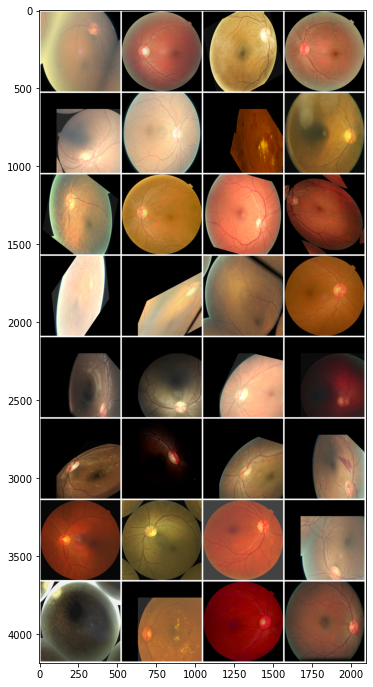

In [29]:
plt.figure(figsize=(9, 12))
plt.imshow(grid_img)